In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
np.set_printoptions(suppress=True)

/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [3]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [4]:
vec = pickle.load(open('preprocess/SST/sst.p', 'rb'))

In [5]:
import model.Attn_Word_Attn as AttnModel
Model = AttnModel.Model

In [6]:
vocab_size = vec.vocab_size
embed_size = vec.word_dim

In [7]:
X, Xt = vec.seq_text['train'], vec.seq_text['test']
y, yt = vec.label['train'], vec.label['test']

In [8]:
ind_1 = [i for i, x in enumerate(X) if len(x) <= 2]
X = [x for i, x in enumerate(X) if i not in ind_1]
y = [x for i, x in enumerate(y) if i not in ind_1]
print(len(ind_1))
ind_1 = [i for i, x in enumerate(Xt) if len(x) <= 2]
Xt = [x for i, x in enumerate(Xt) if i not in ind_1]
yt = [x for i, x in enumerate(yt) if i not in ind_1]

0


In [9]:
def train(std, lreg, kld=False, name='') :
    model = Model(vocab_size, embed_size, 32, dirname='sst', pre_embed=vec.embeddings)
    model.std = std
    model.lreg = lreg
    loss_list = []

    for i in tqdm_notebook(range(7)) :
        if kld :
            if i >= 1 :
                correct=True
            else :
                correct=False
        else : correct = False
        loss, losses = model.train(X, y, correct=correct)
        print(loss)
        loss_list.append(losses)
        o, he = model.evaluate(Xt)
        o = np.array(o)
        rep = classification_report(yt, (o > 0.5))
        print(rep)
        stmt = '%s, %s, %s, %s' % (i, loss, std, lreg)
        dirname = model.save_values(add_name=name+'_test_'+str(std)+'_'+str(lreg), save_model=(not np.isnan(loss)))
        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    pickle.dump(loss_list, open(dirname + '/loss_list.p', 'wb'))
    model.loss_list = loss_list
    return model

In [ ]:
model = train(0.1, 1, kld=True, name='test_kld')

In [10]:
def load_model(dirname) :
    model = Model(vocab_size, embed_size, 32, dirname='sst', pre_embed=vec.embeddings)
    model.std = 0.1
    model.lreg = 1
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [11]:
dirname_normal = 'outputs/attn_word_attn_sst/ThuAug1605:01:282018_test_test_0.1_1/'
model_normal = load_model(dirname_normal)

Setting Embedding


In [12]:
dirname_kld = 'outputs/attn_word_attn_sst/ThuAug1605:09:142018_test_kld_test_0.1_1/'
model_kld = load_model(dirname_kld)

Setting Embedding


Evaluation
==========

In [13]:
Xtest = Xt
ytest = yt

In [14]:
def generate_sampled(model) :
    attn_list = []
    sampled_list = []
    for i in range(10) :
        _, attn, sampled = model.evaluate(Xtest, sample=True)
        attn_list.append(attn)
        sampled_list.append(sampled)
        
    pickle.dump([attn_list, sampled_list], open(model.dirname + '/sampled.p', 'wb'))
        
def load_sampled(model) :
    attn_list, sampled_list = pickle.load(open(model.dirname + '/sampled.p', 'rb'))
    attn = list(map(list, zip(*attn_list)))
    attn = [np.array(x) for x in attn]
    attn = [x.mean(0) for x in attn]

    sampled = list(map(list, zip(*sampled_list)))
    sampled = [np.array(x) for x in sampled]
    sampled = [x.mean(0) for x in sampled]

    model.attn = attn
    model.sampled = sampled

In [15]:
generate_sampled(model_normal)
generate_sampled(model_kld)

KeyboardInterrupt: 

In [16]:
from scipy.stats import spearmanr, kendalltau

def calc_corr(model) :
    a = []
    b = []
    for i in range(len(model.attn)) :
        a += list(model.attn[i])
        b += list(model.sampled[i])
        
    ind = [i for i, (x, y) in enumerate(zip(a, b)) if y == y and x > 0.0]

    a = np.array(a)[ind]
    b = np.array(b)[ind]
    model.spear = spearmanr(a, b)
    model.kendall = kendalltau(a, b)
    model.pear = np.corrcoef(a, b)

In [21]:
load_sampled(model_normal)
load_sampled(model_kld)

In [22]:
calc_corr(model_normal)
calc_corr(model_kld)

In [32]:
from cycler import cycler
import matplotlib.pyplot as plt

plt.rc('lines', linewidth=2)
line_cycle = cycler('linestyle', ['-', '--'])
color_cycle = cycler('color', ['#1f78b4', '#33a02c'])
marker_cycle = cycler('marker', ['+', '2'])

def plot(attn, sampled, ax, name, marker) :
    a = []
    b = []
    for i in range(len(attn)) :
        a += list(attn[i])
        b += list(sampled[i])
        
    ind = [i for i, (x, y) in enumerate(zip(a, b)) if y == y and x > 0.0]

    a = np.array(a)[ind]
    b = np.array(b)[ind]
    print(spearmanr(a, b))
    print(kendalltau(a, b))
    print(np.corrcoef(a, b))
    fit = np.polyfit(a, b, deg=1)
    r = np.linspace(0, 1, 10)
#     ax.plot(r, fit[0] * r + fit[1], label=name + (r' ($\rho$=%.3f'%np.corrcoef(a, b)[0, 1]) + ')')
    ax.scatter(a, b, s=0.8, alpha=0.5, marker=marker)
    ax.set_xlabel('Attention')
    ax.set_ylabel('Expected Normalised KL divergence')

SpearmanrResult(correlation=0.7530708113065351, pvalue=0.0)
KendalltauResult(correlation=0.5950412748362897, pvalue=0.0)
[[1.         0.86891306]
 [0.86891306 1.        ]]
SpearmanrResult(correlation=0.7314923111206573, pvalue=0.0)
KendalltauResult(correlation=0.5490386194918985, pvalue=0.0)
[[1.         0.79273016]
 [0.79273016 1.        ]]


No handles with labels found to put in legend.


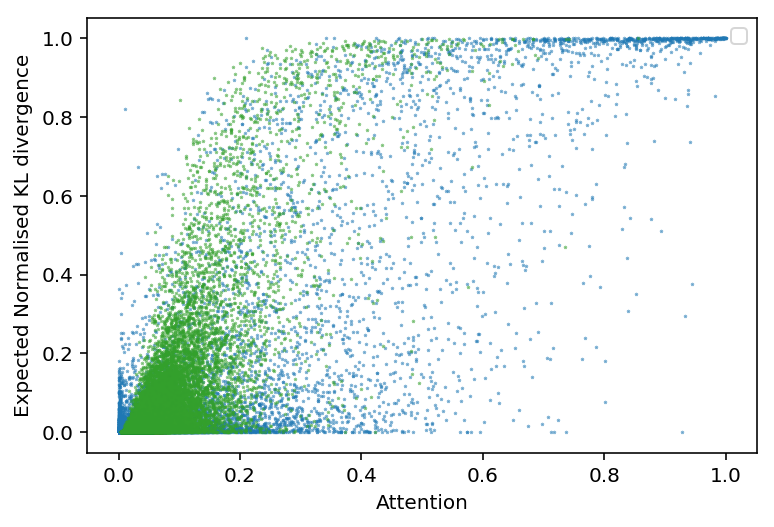

In [33]:
fig, ax = plt.subplots()
ax.set_prop_cycle(line_cycle + color_cycle) # + marker_cycle)
plot(model_normal.attn, model_normal.sampled, ax, name='Normal', marker='*')
plot(model_kld.attn, model_kld.sampled, ax, name='Regularized', marker='*')

ax.legend()

Attention Maps
==============

In [26]:
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

def showAttention(fig, ax, input_sentence, attnn, kldn, attnk, kldk):
    # Set up figure with colorbar
#     ax = fig.add_subplot()
    attentions = np.stack([attnn, kldn, attnk, kldk], axis=0)
    mask1 = np.zeros(attentions.shape)
    mask1[1, :] = 1
    mask1[3, :]
    
    a1 = np.ma.masked_array(attentions, mask1)
    im = ax.imshow(a1, cmap='Reds', vmin=0, vmax=1, interpolation='none')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="10%", pad=0.05)
#     fig.colorbar(im, cax=cax, ax=ax)
#     cbar = fig.colorbar(cax, orientation='vertical')
#     cbar.ax.set_yticklabels([])
    
    mask1 = np.zeros(attentions.shape)
    mask1[0, :] = 1
    mask1[2, :] = 1
    
    a1 = np.ma.masked_array(attentions, mask1)
    im = ax.imshow(a1, cmap='Greens', vmin=0, vmax=1, interpolation='none')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("left", size="10%", pad=0.05)
#     fig.colorbar(im, cax=cax, ax=ax)
    #cbar.ax.set_yticklabels([])
    
    # Set up axes
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(input_sentence, rotation=85)
    
    ax.set_yticks([])
    ax.set_yticklabels([])

#     plt.show()

In [27]:
idxs = []
for idx, (att, sm) in enumerate(zip(model_normal.attn, model_normal.sampled)) :
    kld = (att * np.log((att + 1e-8)/(sm + 1e-8))).sum()
    if kld != kld :
        continue
    if kld > 1.5 :
        idxs.append(idx)

In [28]:
not_eq = 0
for idx, (i, j) in enumerate(zip(normal_pred, kld_pred)) :
    if (i > 0.5) == (j > 0.5) :
        print(idx, i, j)
        not_eq += 1
print(not_eq)

NameError: name 'normal_pred' is not defined

In [29]:
n = 422

NameError: name 'pdf' is not defined

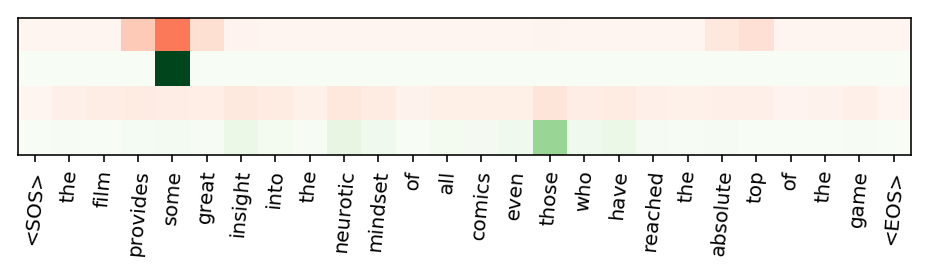

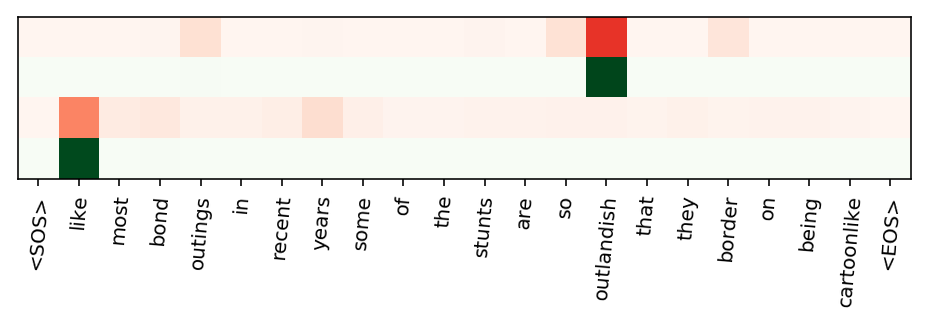

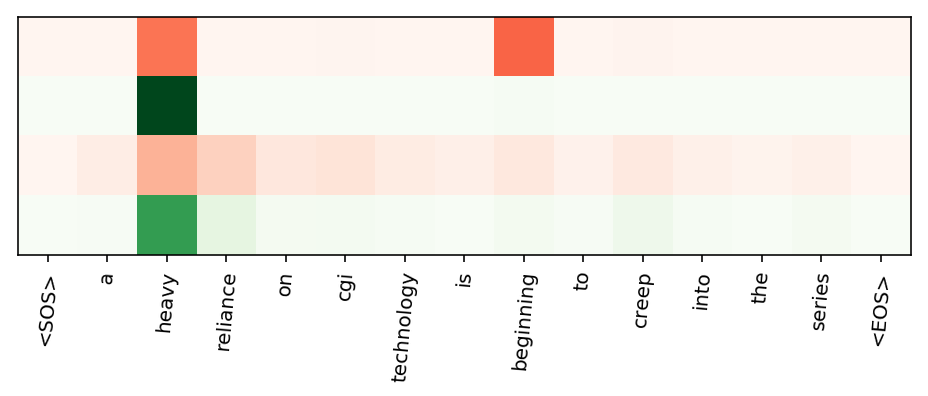

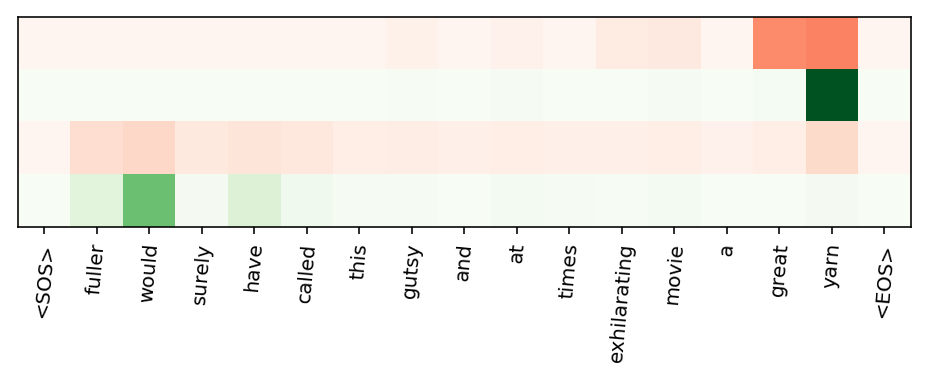

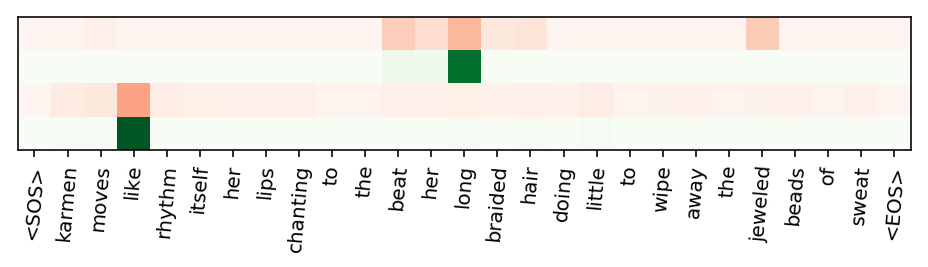

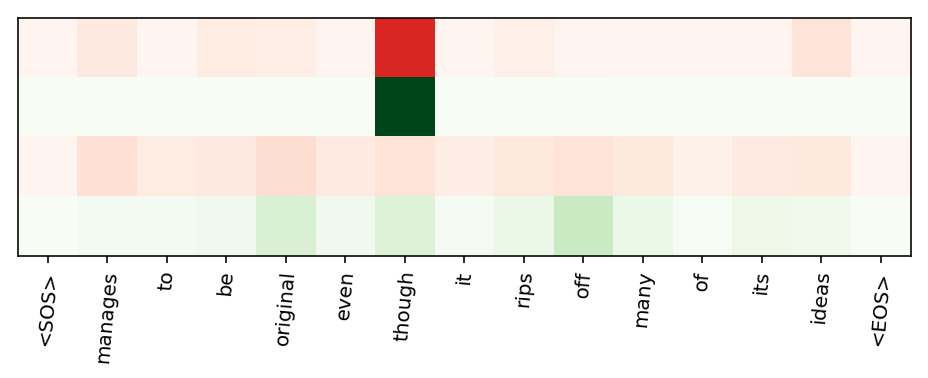

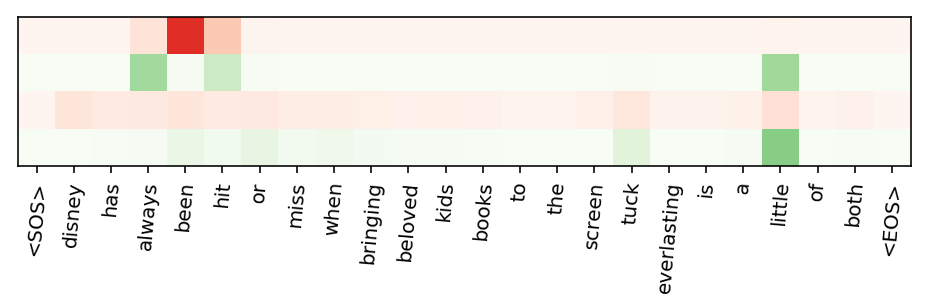

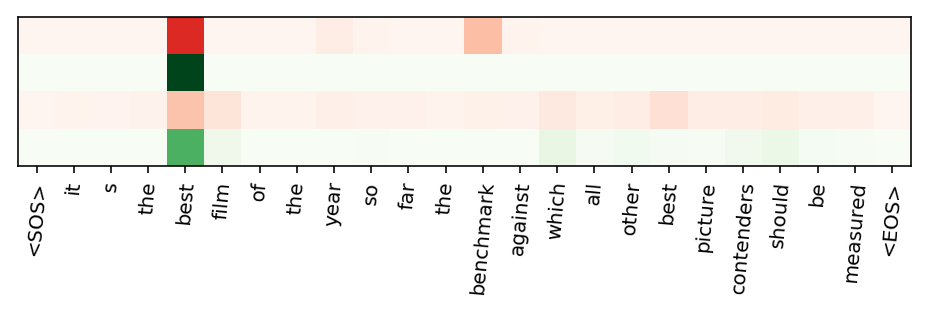

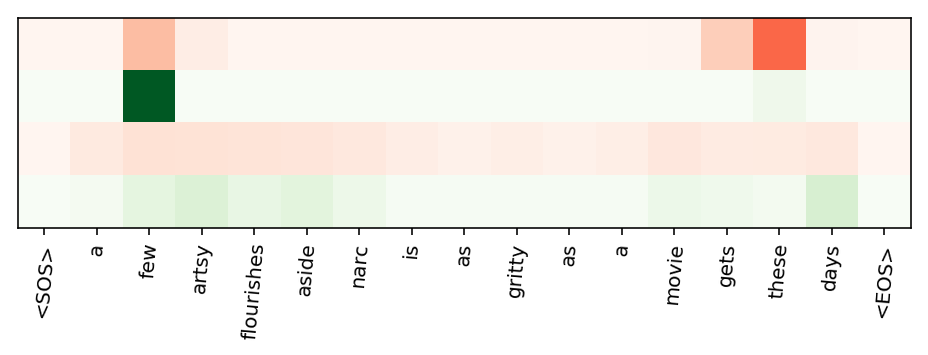

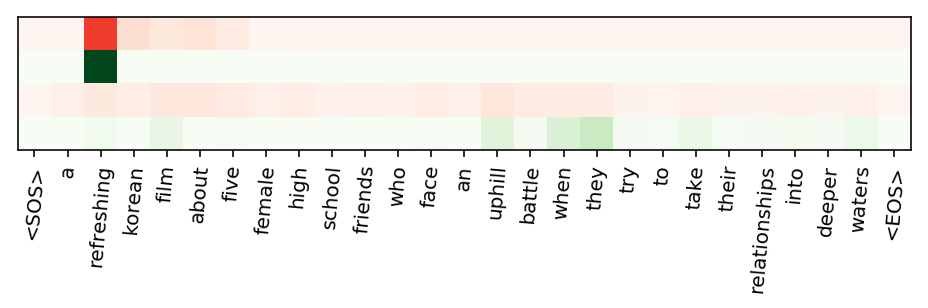

In [30]:
import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output_sst.pdf")
for i, n in enumerate(idxs[:10]) :
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    showAttention(fig, axes, [vec.idx2word[x] for x in Xtest[n]], model_normal.attn[n][:len(Xtest[n])], model_normal.sampled[n][:len(Xtest[n])],
                                                                model_kld.attn[n][:len(Xtest[n])], model_kld.sampled[n][:len(Xtest[n])])
#     pdf.savefig(fig)
pdf.close()

In [ ]:
plt.show()